In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from xgboost import XGBRegressor

import datetime

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

from lightgbm import LGBMRegressor

 # Import and View Datasets

In [ ]:
from google.colab import files
import zipfile
import pandas as pd
import io

# Step 1: Upload the zip file to Google Colab
uploaded = files.upload()


Saving store-sales-time-series-forecasting.zip to store-sales-time-series-forecasting.zip


In [ ]:
# Step 2: Unzip the file
zip_filename = next(iter(uploaded))
with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), 'r') as zip_ref:
    # Step 3: Load CSV files into Pandas DataFrames
    csv_files = [file for file in zip_ref.namelist() if file.endswith('.csv')]

    # Create a dictionary to store DataFrames
    dataframes = {}

    for csv_file in csv_files:
        with zip_ref.open(csv_file) as file:
            # Load CSV into Pandas DataFrame
            df = pd.read_csv(file)
            # Store DataFrame in the dictionary
            dataframes[csv_file] = df

In [ ]:
dataframes


{'holidays_events.csv':            date        type    locale locale_name  \
 0    2012-03-02     Holiday     Local       Manta   
 1    2012-04-01     Holiday  Regional    Cotopaxi   
 2    2012-04-12     Holiday     Local      Cuenca   
 3    2012-04-14     Holiday     Local    Libertad   
 4    2012-04-21     Holiday     Local    Riobamba   
 ..          ...         ...       ...         ...   
 345  2017-12-22  Additional  National     Ecuador   
 346  2017-12-23  Additional  National     Ecuador   
 347  2017-12-24  Additional  National     Ecuador   
 348  2017-12-25     Holiday  National     Ecuador   
 349  2017-12-26  Additional  National     Ecuador   
 
                        description  transferred  
 0               Fundacion de Manta        False  
 1    Provincializacion de Cotopaxi        False  
 2              Fundacion de Cuenca        False  
 3        Cantonizacion de Libertad        False  
 4        Cantonizacion de Riobamba        False  
 ..                  

In [ ]:
holidays_events = dataframes['holidays_events.csv']
oil = dataframes['oil.csv']
stores = dataframes['stores.csv']
transactions = dataframes['transactions.csv']
train = dataframes['train.csv']
test = dataframes['test.csv']


## Train - Summary
* The training dataset includes time series data for the features store_nbr, family, and onpromotion, along with the target variable sales.
* The store_nbr feature denotes the specific store where the products are being sold.
* The family feature provides information about the type or category of the product being sold.
* The sales variable represents the total sales for a product family at a particular store on a specific date. It's worth noting that fractional values are permissible, reflecting instances where products are sold in non-whole units (e.g., 1.5 kg of cheese instead of an entire bag of chips).
* The onpromotion feature indicates the total count of items within a product family that were promoted at a store on a given date.

In [ ]:
train['date'] = train['date'].astype('datetime64[ns]')
test['date'] = test['date'].astype('datetime64[ns]')

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [ ]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   id           3000888 non-null  int64         
 1   date         3000888 non-null  datetime64[ns]
 2   store_nbr    3000888 non-null  int64         
 3   family       3000888 non-null  object        
 4   sales        3000888 non-null  float64       
 5   onpromotion  3000888 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [ ]:
print(f'There are {len(train.family.unique())} different Product Families')
print(f'There are {len(train.store_nbr.unique())} different Stores')

There are 33 different Product Families
There are 54 different Stores


In [ ]:
product_families = train['family'].unique()

In [ ]:
train[['family']].value_counts()

family                    
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
C

In [ ]:
train[['store_nbr']].value_counts()

store_nbr
1            55572
41           55572
30           55572
31           55572
32           55572
33           55572
34           55572
35           55572
36           55572
37           55572
38           55572
39           55572
40           55572
42           55572
2            55572
43           55572
44           55572
45           55572
46           55572
47           55572
48           55572
49           55572
50           55572
51           55572
52           55572
53           55572
29           55572
28           55572
27           55572
26           55572
3            55572
4            55572
5            55572
6            55572
7            55572
8            55572
9            55572
10           55572
11           55572
12           55572
13           55572
14           55572
15           55572
16           55572
17           55572
18           55572
19           55572
20           55572
21           55572
22           55572
23           55572
24           55572
25

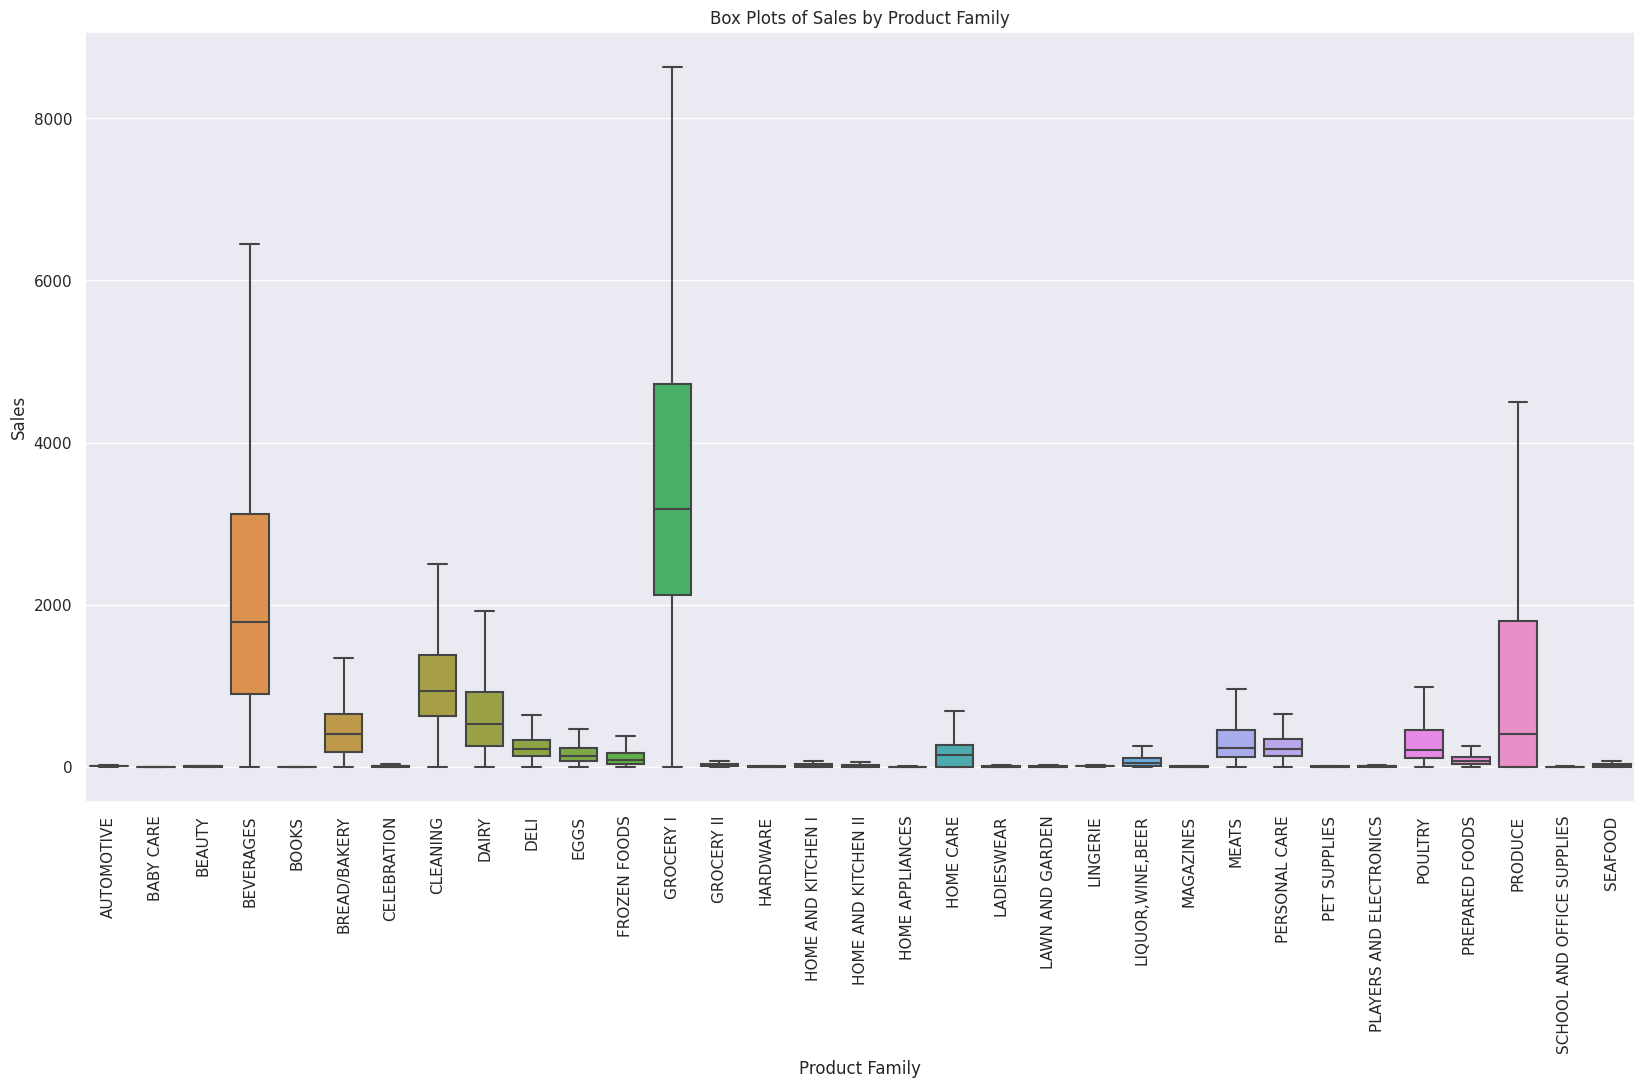

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x=train['family'], y=train['sales'], showfliers = False)

plt.xticks(rotation=90)
plt.xlabel('Product Family')
plt.ylabel('Sales')

plt.title('Box Plots of Sales by Product Family')

plt.show()

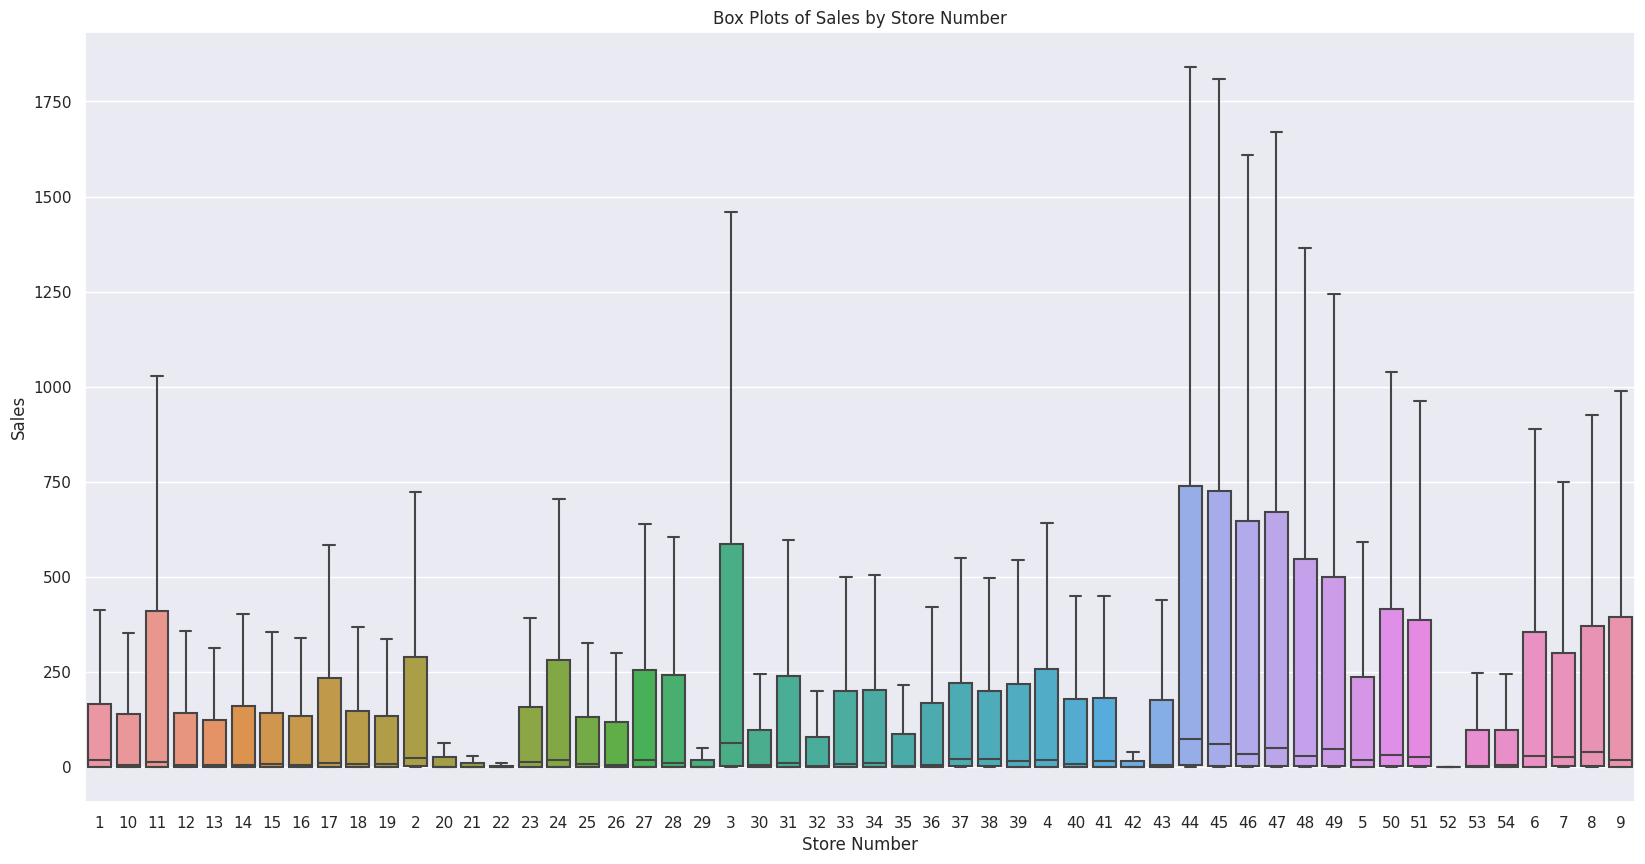

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x=train['store_nbr'].astype(str), y=train['sales'], showfliers = False)

plt.xlabel('Store Number')
plt.ylabel('Sales')

plt.title('Box Plots of Sales by Store Number')
plt.show()

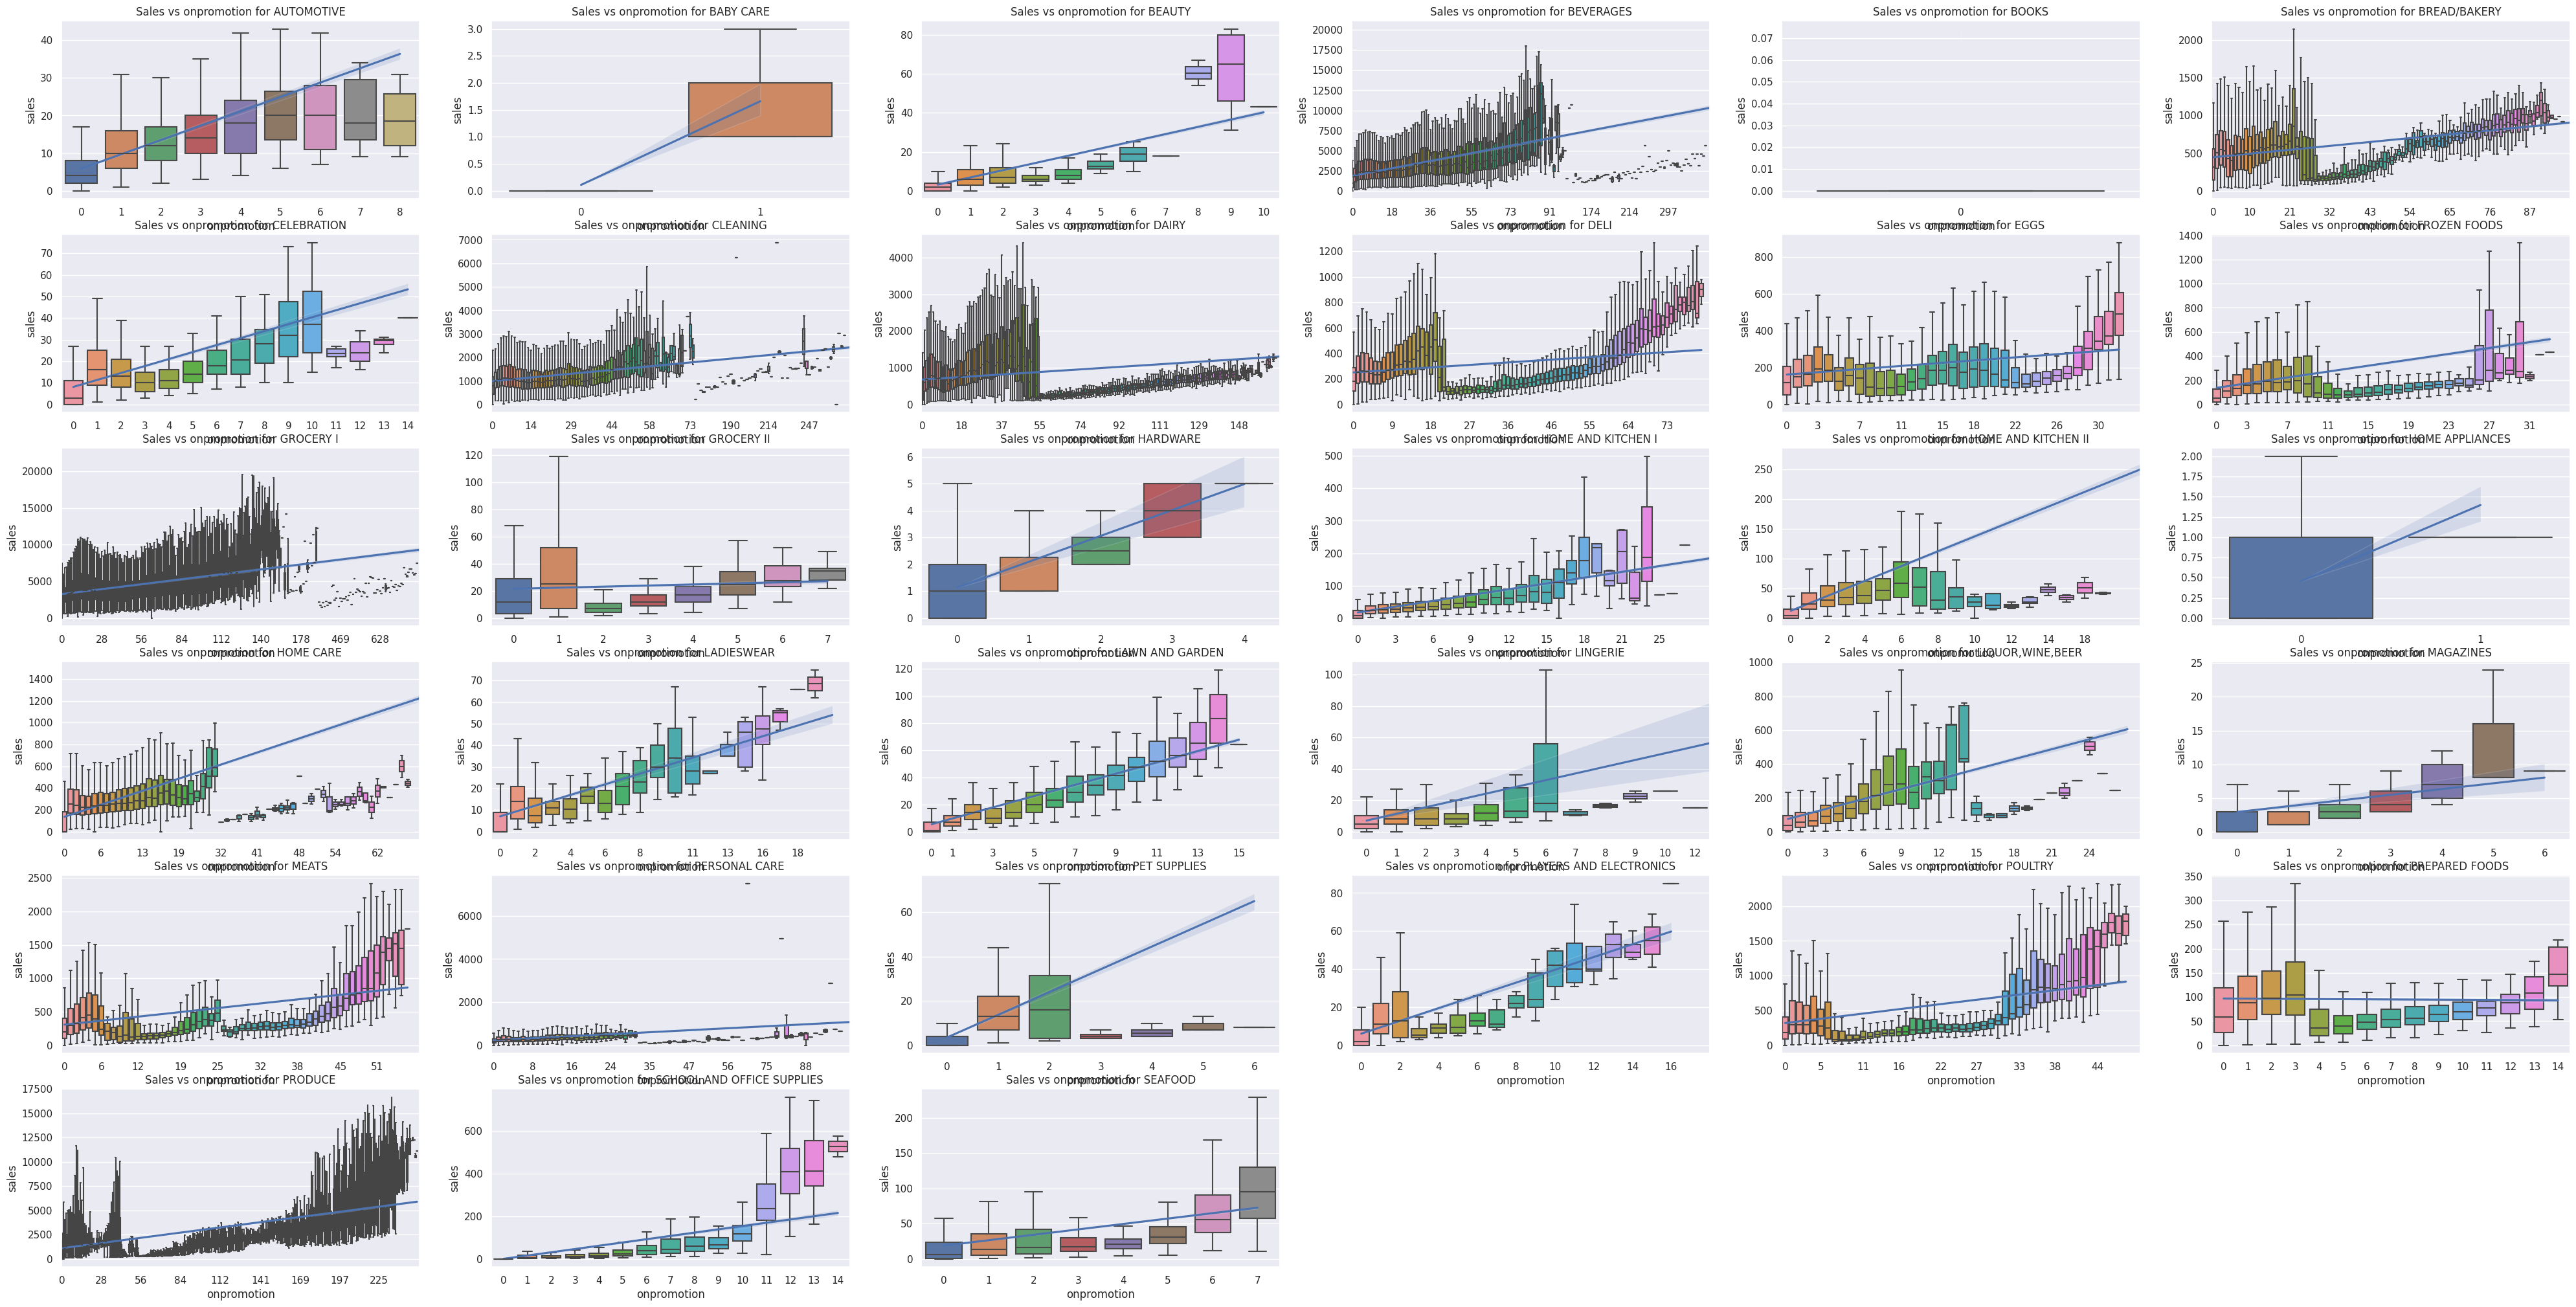

In [ ]:
plt.figure(figsize=(50,25))

palette = sns.color_palette(None, len(product_families))


for n, family in enumerate(product_families):

    plt.subplot(6,6,n+1)

    family_mask = train['family'] == family

    sns.boxplot(x="onpromotion", y="sales", data=train[family_mask], showfliers = False)
    sns.regplot(x="onpromotion", y="sales", data=train[family_mask], scatter=False)

    x_max = len(train[family_mask]['onpromotion'].unique())

    plt.xlim([-0.5,x_max-0.5])

    if x_max > 15:
        plt.xticks(np.linspace(0,x_max+1,10,dtype=int))


    plt.title(f'Sales vs onpromotion for {family}')

plt.show()

In [ ]:
promotions_mask = train['onpromotion'] > 0

promoitions_min = train[promotions_mask].date.min()
promoitions_max = train[promotions_mask].date.max()

print(f'Promotions Start Date: {promoitions_min}')
print(f'Promotions End Date: {promoitions_max}')


Promotions Start Date: 2014-04-01 00:00:00
Promotions End Date: 2017-08-15 00:00:00


In [ ]:
print(f'Start Date: {train.date.min()}')
print(f'End Date: {train.date.max()}')
print(f'Number of Days: {len(train.date.unique())}')

Start Date: 2013-01-01 00:00:00
End Date: 2017-08-15 00:00:00
Number of Days: 1684


## Train - Insights
* No missing data requires handling in our dataset.
* We have 33 distinct product families and 54 unique stores.
* The equality in the number of rows for each family/store pairing ensures that historical data is complete for all combinations.
* Extracting features such as day of the week, month, and year allows us to capture temporal trends.
* Sales across product families exhibit more significant variability than store numbers, with 'Grocery I' standing out as the top-selling category. Considering this high variance, employing a model per product family might be optimal for capturing specific patterns.
* Despite the variance, store number remains a potent factor influencing sales, making it a valuable feature.
* A robust correlation exists between on promotion status and sales, but the correlation's nature differs across product families. This discrepancy further supports the case for employing product-specific models.
* The dataset spans from January 1, 2013, to August 15, 2017.
* Notably, promotion data is available only from April 1, 2014, onward, suggesting that focusing on data from this point might be advisable.

## Transactions - Summary
* Total transactions for each store by day

In [ ]:
transactions['date'] = transactions['date'].astype('datetime64[ns]')

In [ ]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [ ]:
transactions.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


Axes(0.125,0.11;0.775x0.77)


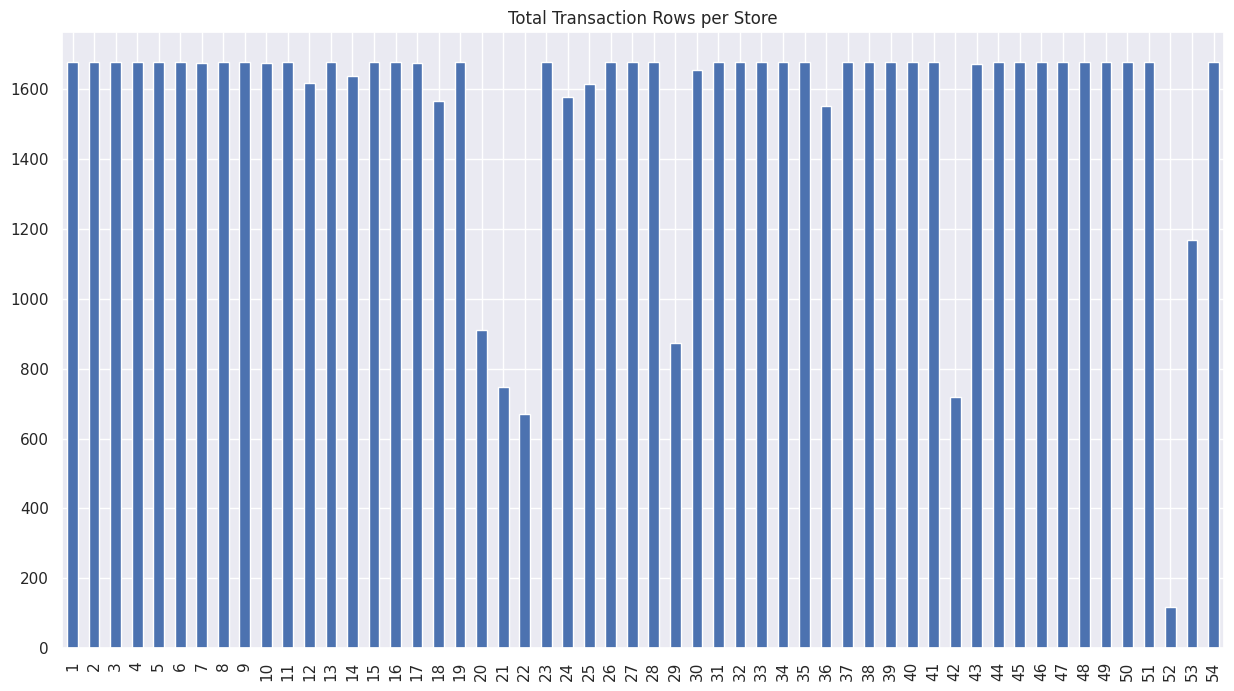

In [ ]:
plt.figure(figsize=(15,8))

print(transactions['store_nbr'].value_counts().sort_index().plot(kind='bar'))

plt.title('Total Transaction Rows per Store')

plt.show()

In [ ]:
print(f'Start Date: {transactions.date.min()}')
print(f'End Date: {transactions.date.max()}')
print(f'Number of Days: {len(transactions.date.unique())}')

Start Date: 2013-01-01 00:00:00
End Date: 2017-08-15 00:00:00
Number of Days: 1682


## Transactions - Insights
* We possess a record of daily total transactions per store.
* The transaction counts exhibit a considerable range, with a minimum of 5 and a maximum of 8359 transactions per store/product.
* Test data lacks transaction information, requiring lag features to extend at least 16 days into the past for utilization in the test dataset.
* Historical data availability varies across stores, and data for two days is missing, necessitating imputation with zeros to complete the dataset.

## Stores - Summary
* Store metadata, including city, state, type, and cluster.
* cluster is a grouping of similar stores.

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


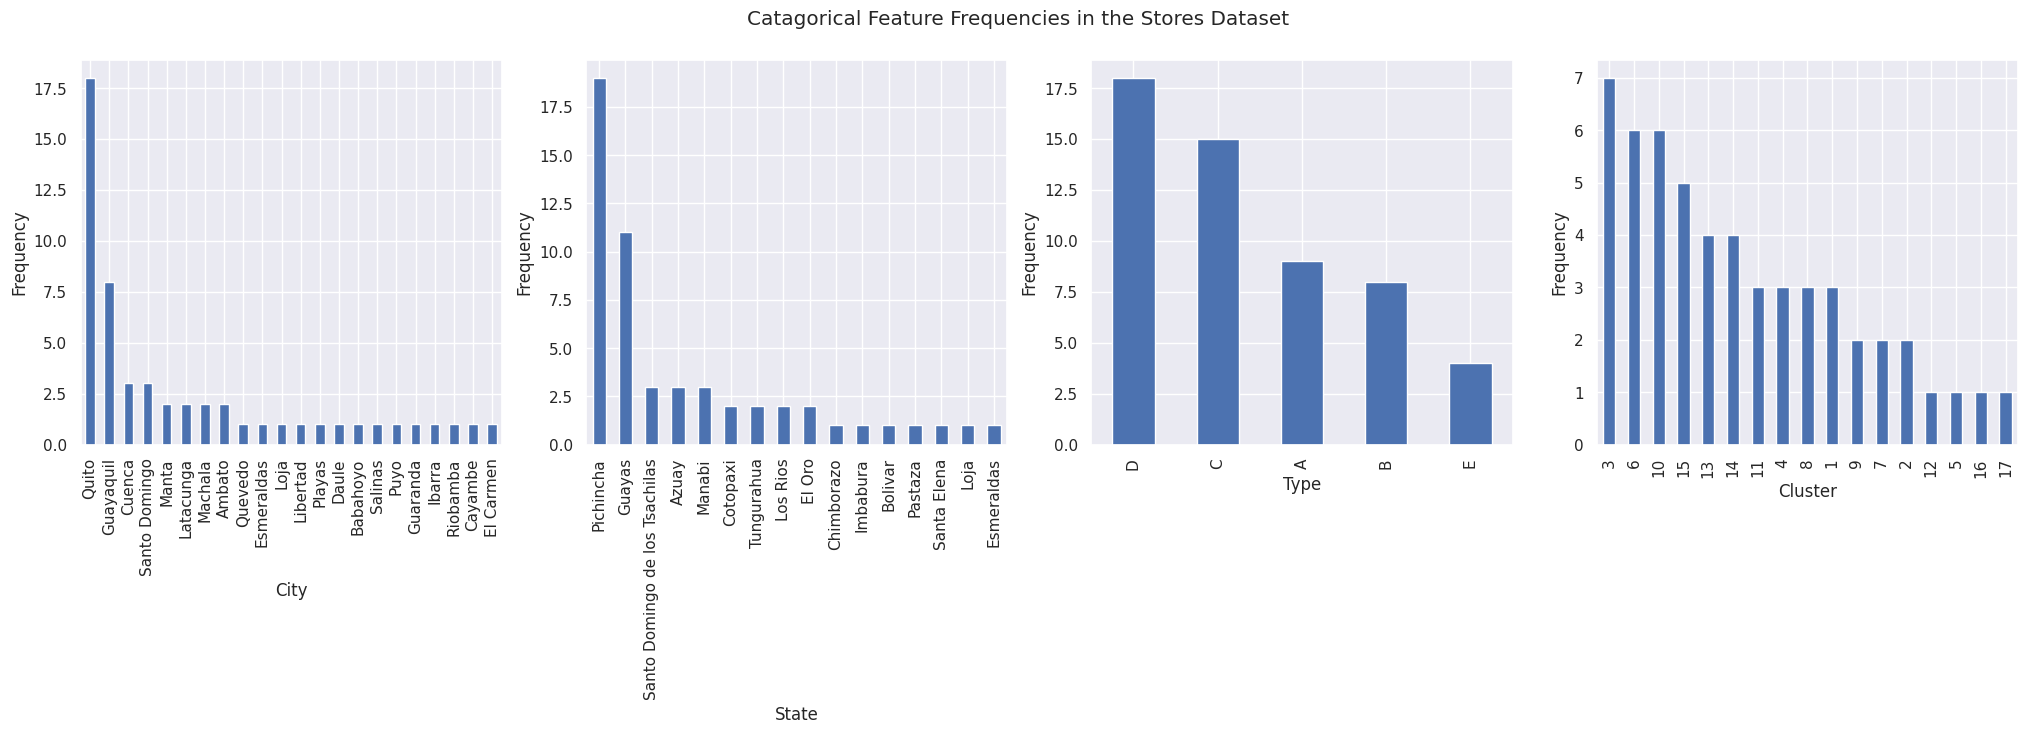

In [ ]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
stores['city'].value_counts().plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Frequency')


plt.subplot(1,4,2)
stores['state'].value_counts().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Frequency')

plt.subplot(1,4,3)
stores['type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Frequency')


plt.subplot(1,4,4)
stores['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')


plt.suptitle('Catagorical Feature Frequencies in the Stores Dataset')

plt.show()

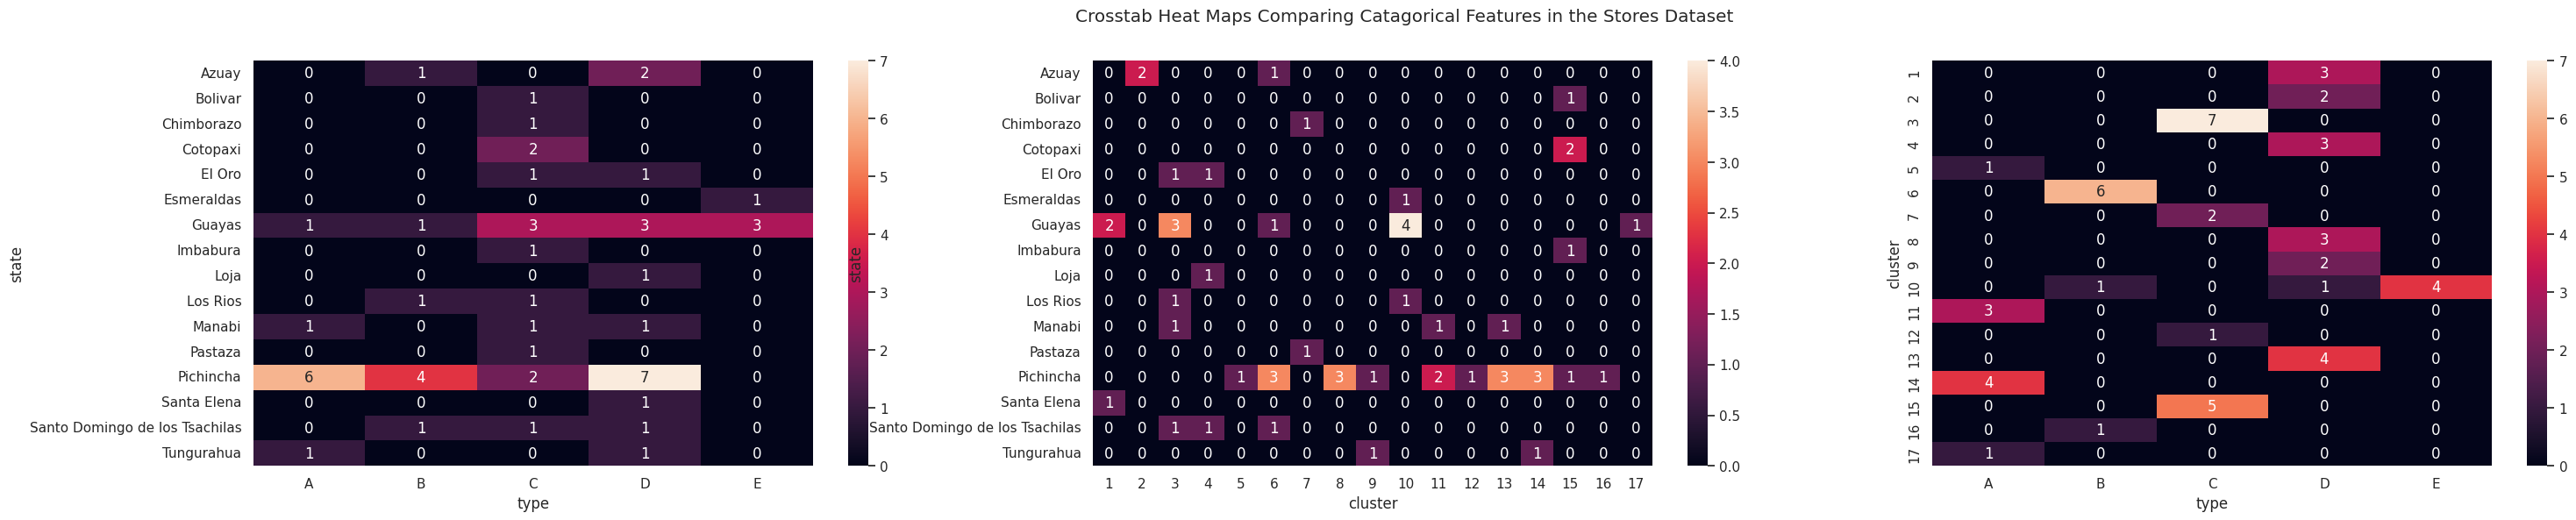

In [ ]:
plt.figure(figsize=(35,6))

plt.subplot(1,3,1)
state_type_crosstab = pd.crosstab(stores['state'], stores['type'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of State vs Store Type')

plt.subplot(1,3,2)
state_type_crosstab = pd.crosstab(stores['state'], stores['cluster'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of State vs Cluster')

plt.subplot(1,3,3)
state_type_crosstab = pd.crosstab(stores['cluster'], stores['type'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Type vs Cluster')

plt.suptitle('Crosstab Heat Maps Comparing Catagorical Features in the Stores Dataset')

plt.show()

In [ ]:
sales_store = train.merge(stores, how='left', on='store_nbr')

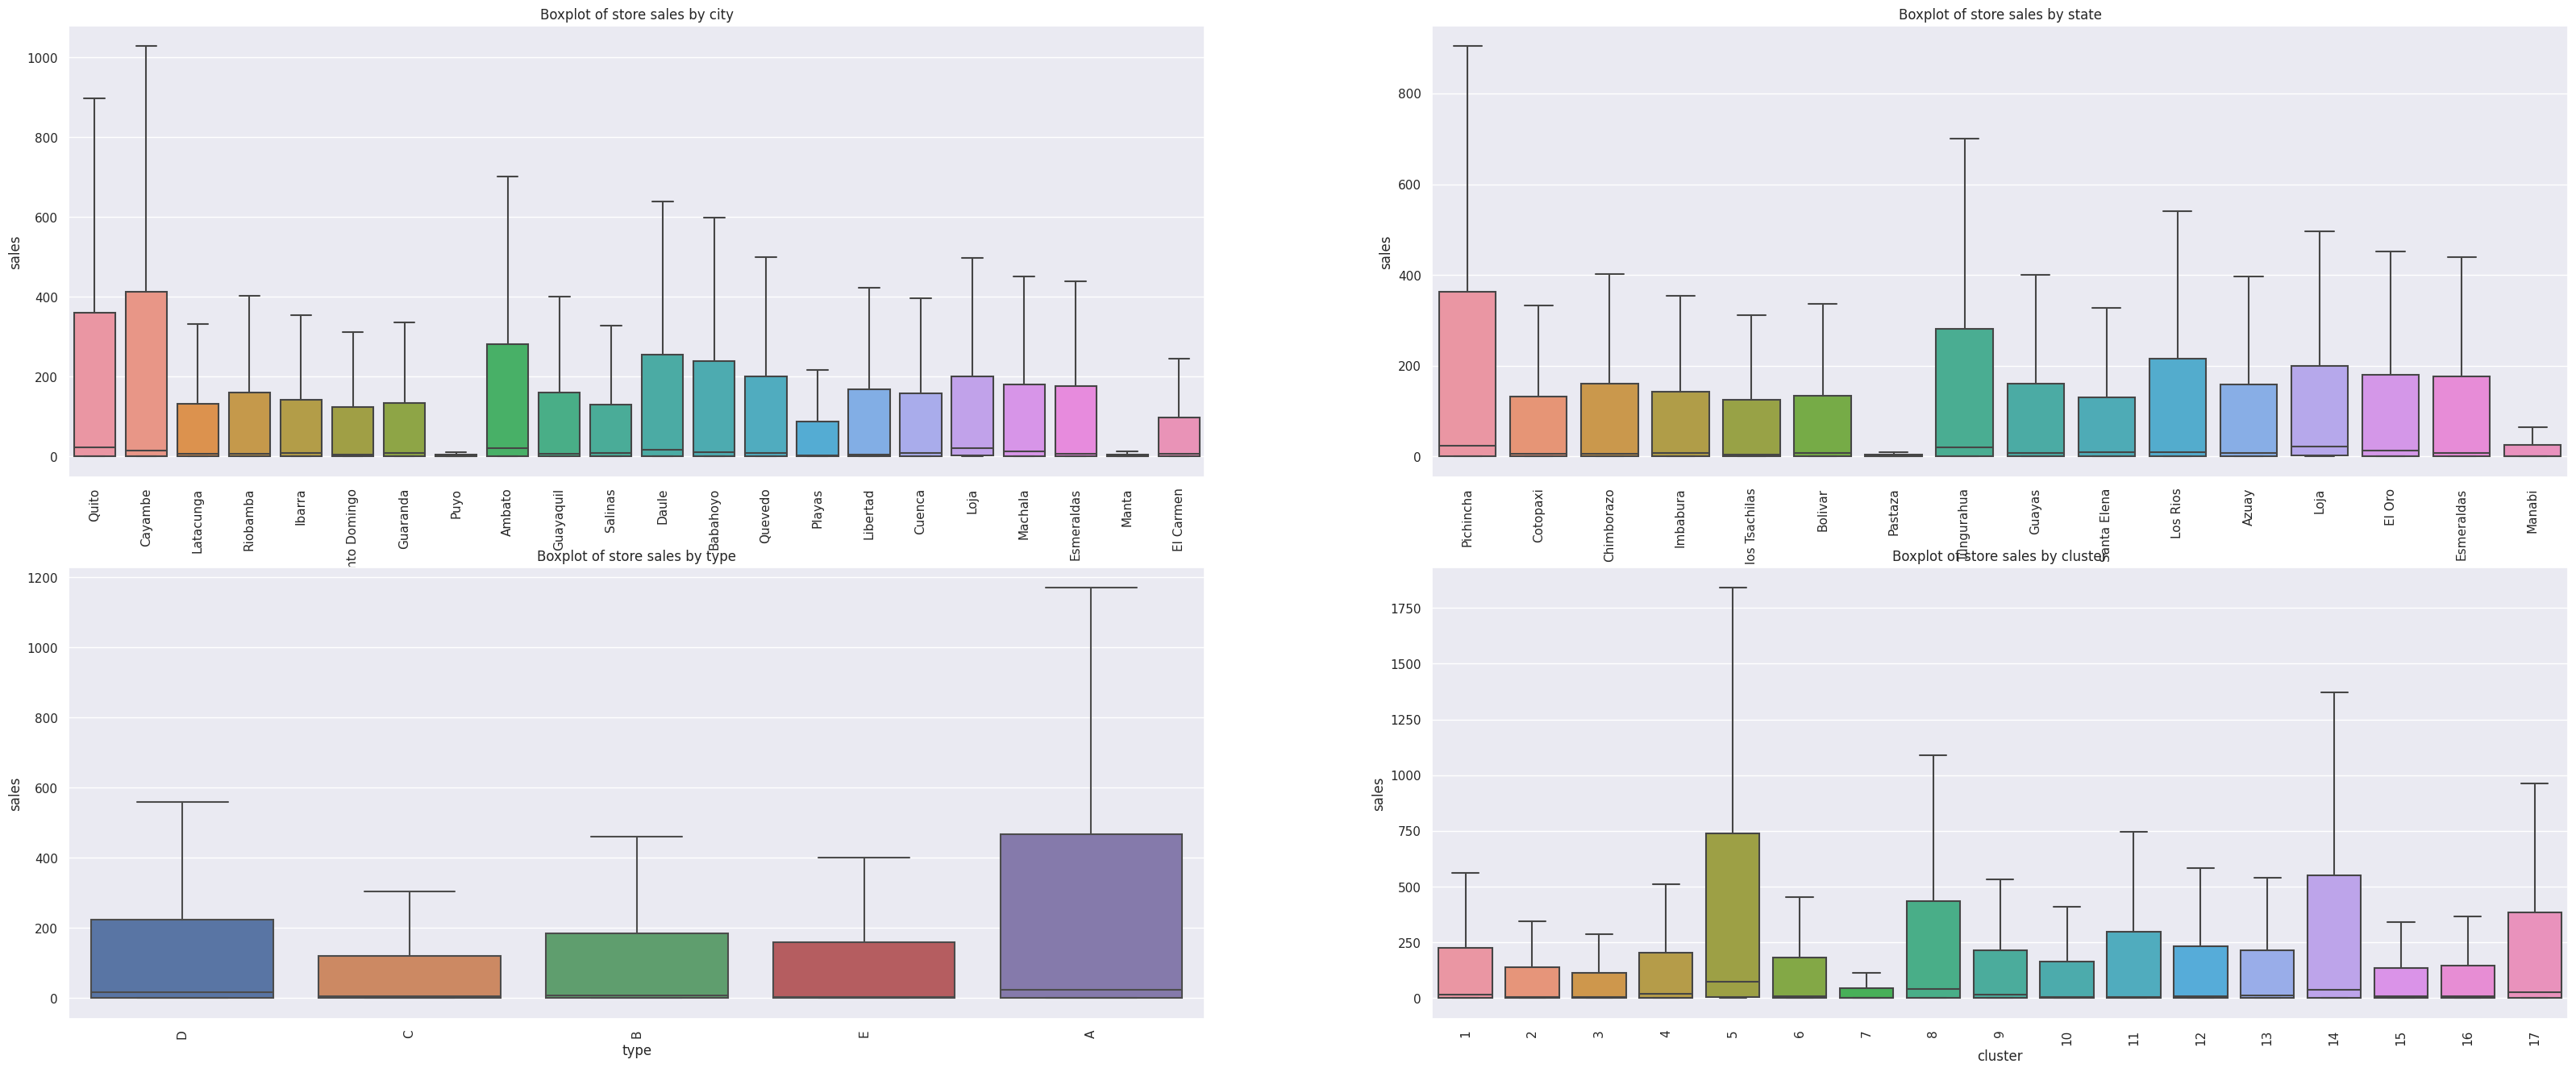

In [ ]:
plt.figure(figsize=(40,16))

plt.subplot(2,2,1)
sns.boxplot(x=sales_store['city'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by city')

plt.subplot(2,2,2)
sns.boxplot(x=sales_store['state'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by state')

plt.subplot(2,2,3)
sns.boxplot(x=sales_store['type'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by type')

plt.subplot(2,2,4)
sns.boxplot(x=sales_store['cluster'], y=sales_store['sales'], showfliers = False)
plt.xticks(rotation=90)
plt.title('Boxplot of store sales by cluster')

plt.show()

## Stores - Insight
* Absence of null values is reaffirmed.
* The dataset comprises 54 stores, categorized into 17 clusters and 5 types.
* Quito is the predominant city, exclusive to the Pichincha state.
* Limited correlation exists between State and Type, as well as between State and Cluster; both type and cluster exhibit diverse distributions across states.
* A robust correlation is observed between cluster and type, with the exception of cluster 10, which uniquely encompasses a mix of types. Generally, stores within the same cluster tend to share the same type.

## Holiday - Summary
* Holidays and Events dataset includes metadata.
* It's crucial to focus on the "transferred" column, particularly when a holiday is officially designated for a specific calendar day but is officially moved to another date by the government. In such cases, the transferred day resembles a regular day more than a holiday. To identify the actual celebrated date, one must look for the corresponding row where the type is "Transfer." For instance, the holiday "Independencia de Guayaquil" was officially transferred from 2012-10-09 to 2012-10-12, indicating that it was celebrated on 2012-10-12. Days categorized as "Bridge" represent additional days added to a holiday, often to extend the break across a long weekend. These additional days are typically compensated by the "Work Day" type, denoting a day not originally scheduled for work (e.g., Saturday) meant to offset the Bridge day.
* Further, additional holidays refer to days added to a regular calendar holiday, a common occurrence around events like Christmas, where Christmas Eve becomes a holiday.

In [ ]:
holidays_events['date'] = holidays_events['date'].astype('datetime64[ns]')

In [ ]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [ ]:
holidays_events.describe()

<ipython-input-36-6f3e9072f842>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  holidays_events.describe()


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25 00:00:00,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
first,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN


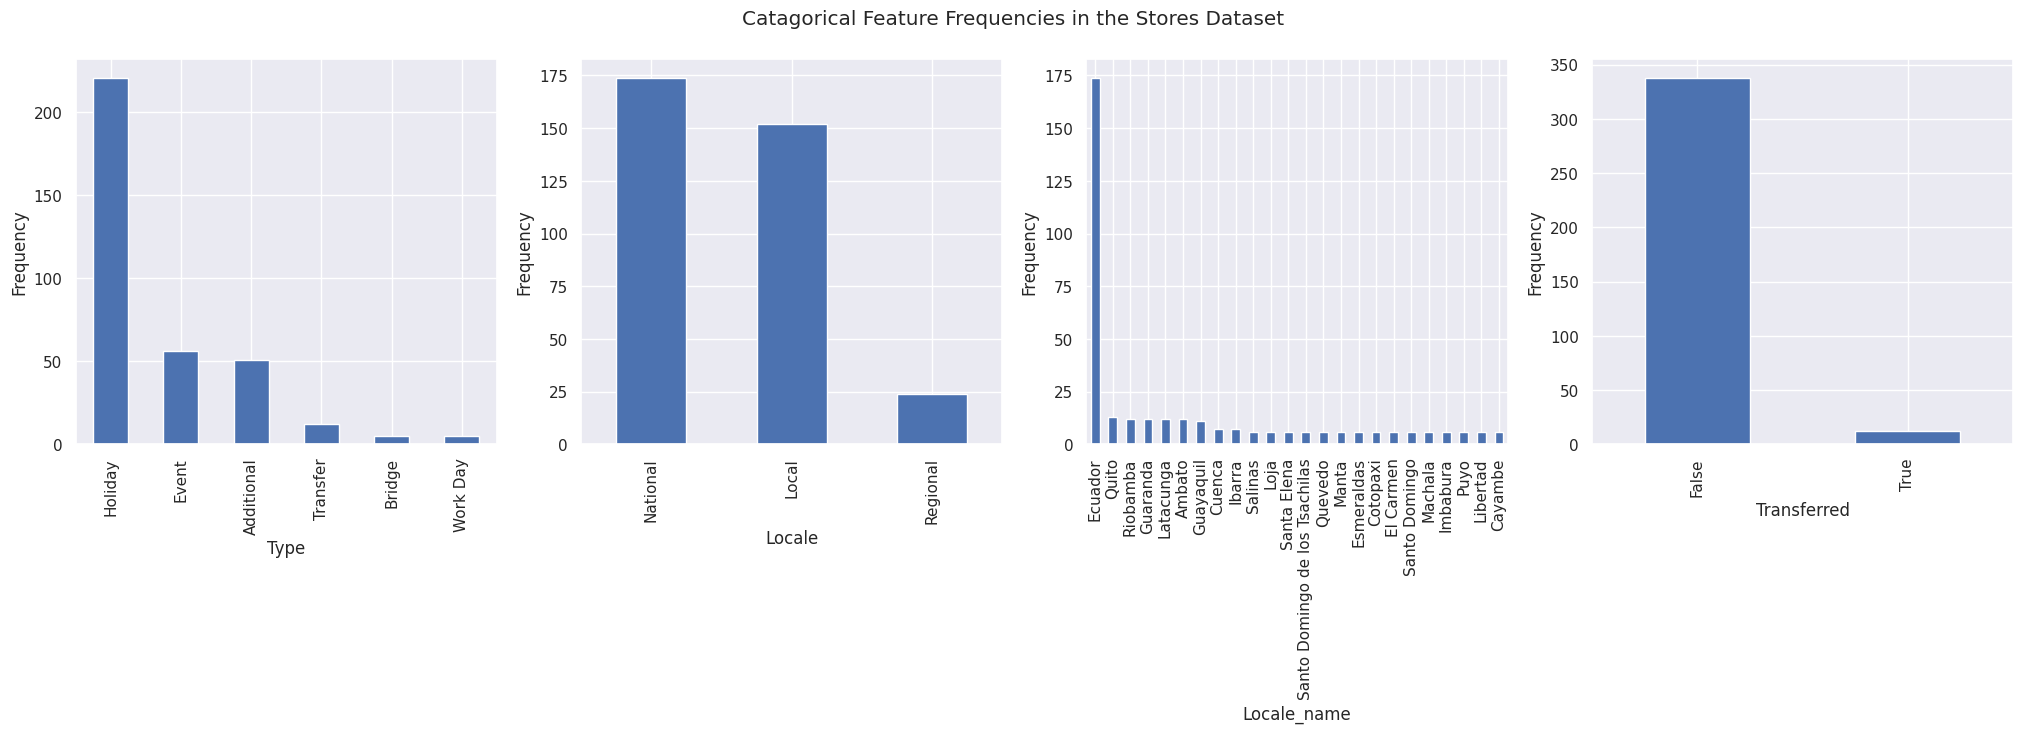

In [ ]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
holidays_events['type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Frequency')


plt.subplot(1,4,2)
holidays_events['locale'].value_counts().plot(kind='bar')
plt.xlabel('Locale')
plt.ylabel('Frequency')

plt.subplot(1,4,3)
holidays_events['locale_name'].value_counts().plot(kind='bar')
plt.xlabel('Locale_name')
plt.ylabel('Frequency')


plt.subplot(1,4,4)
holidays_events['transferred'].value_counts().plot(kind='bar')
plt.xlabel('Transferred')
plt.ylabel('Frequency')


plt.suptitle('Catagorical Feature Frequencies in the Stores Dataset')

plt.show()

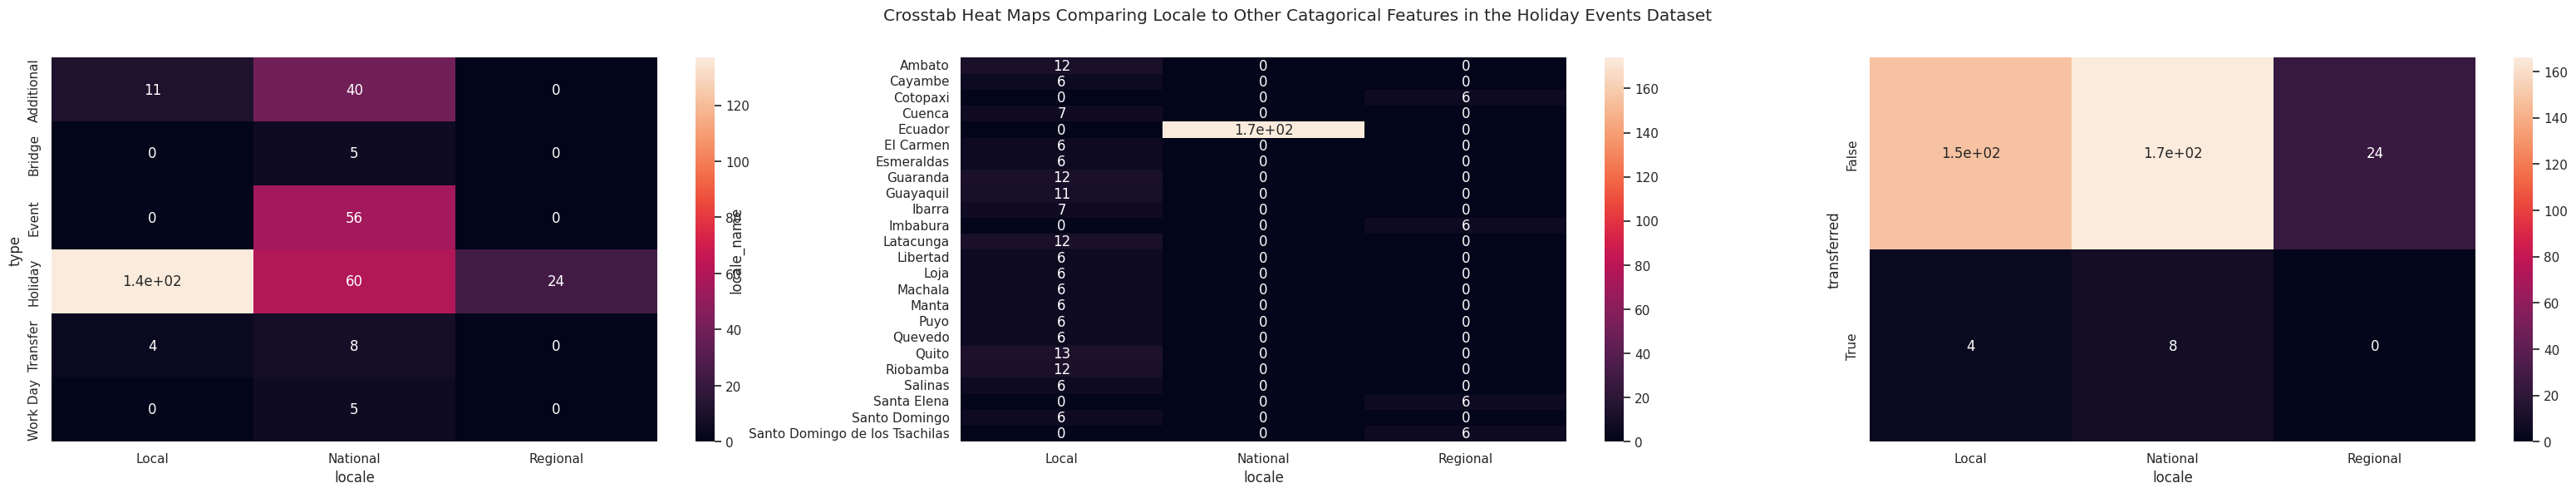

In [ ]:
plt.figure(figsize=(40,6))

plt.subplot(1,3,1)
state_type_crosstab = pd.crosstab(holidays_events['type'], holidays_events['locale'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Type vs Locale')

plt.subplot(1,3,2)
state_type_crosstab = pd.crosstab(holidays_events['locale_name'], holidays_events['locale'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Locale Name vs Locale')


plt.subplot(1,3,3)
state_type_crosstab = pd.crosstab(holidays_events['transferred'], holidays_events['locale'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Transferred vs Locale')

plt.suptitle('Crosstab Heat Maps Comparing Locale to Other Catagorical Features in the Holiday Events Dataset')

plt.show()

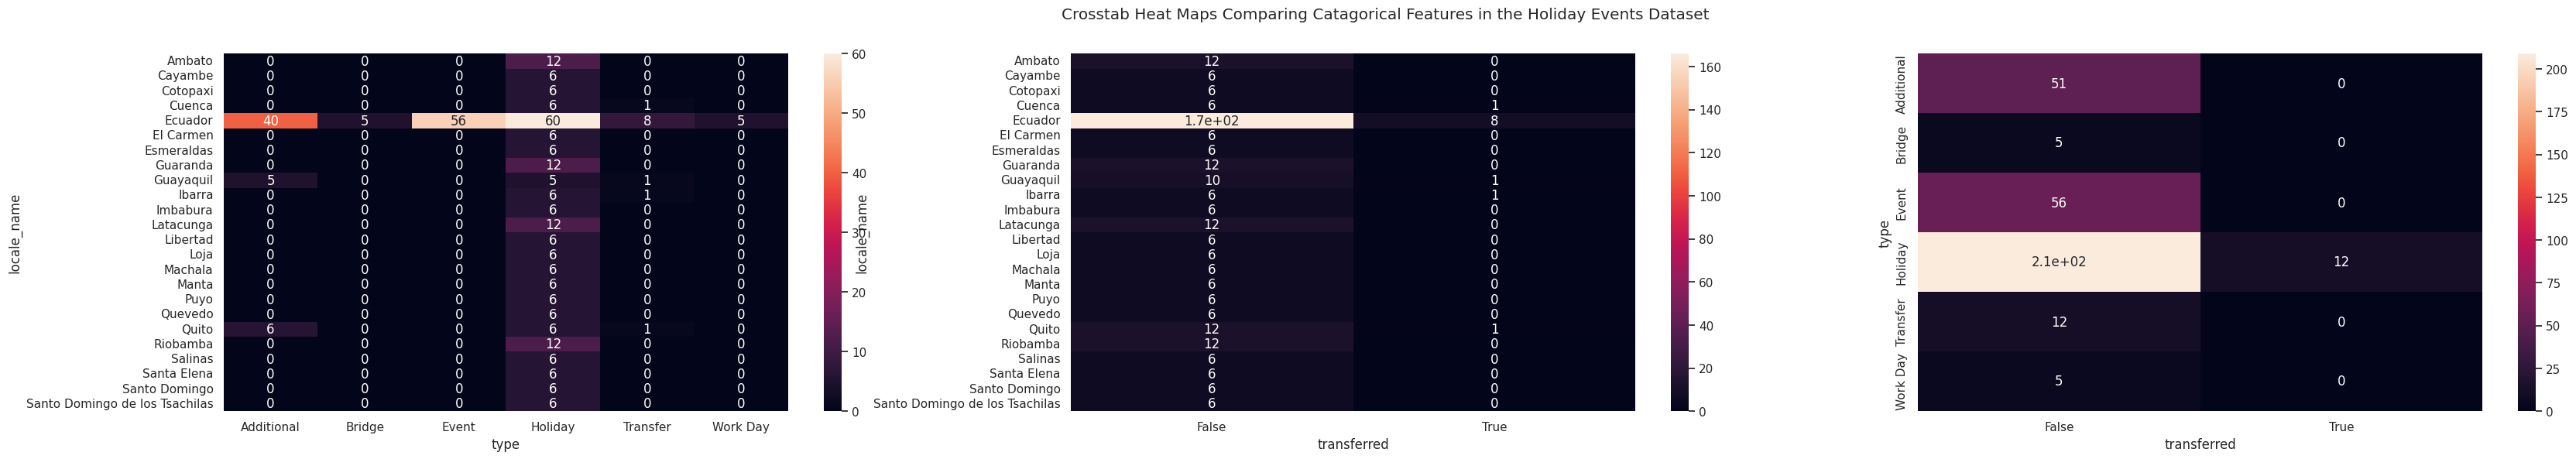

In [ ]:
plt.figure(figsize=(40,6))

plt.subplot(1,3,1)
state_type_crosstab = pd.crosstab(holidays_events['locale_name'], holidays_events['type'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Locale Name vs Type')

plt.subplot(1,3,2)
state_type_crosstab = pd.crosstab(holidays_events['locale_name'], holidays_events['transferred'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Heatmap of Locale Name vs Trasnferred')


plt.subplot(1,3,3)
state_type_crosstab = pd.crosstab(holidays_events['type'], holidays_events['transferred'])
sns.heatmap(state_type_crosstab, annot=True)
plt.plot('Type vs Trasnferred')

plt.suptitle('Crosstab Heat Maps Comparing Catagorical Features in the Holiday Events Dataset')

plt.show()

In [ ]:
print(holidays_events['date'].min())
print(holidays_events['date'].max())

2012-03-02 00:00:00
2017-12-26 00:00:00


## Holiday - Insights
* Absence of null values is confirmed.
* It appears that utilizing the first word in the 'description' column may serve as a potential feature.
* Handling dates is essential based on the "transferred" column; there's a consideration to use the original transferred data, or to retain the flag indicating a transfer.
* When "Locale" is 'local,' it corresponds to the city in the 'stores' dataset. Similarly, when "Locale" is 'Regional,' it links to the state in the 'stores' dataset, and when "Locale" is 'National,' it applies to all stores.
* Ecuador stands out with the highest number of holidays, as locales other than Ecuador do not have holidays classified as 'National Locale.'
* All transferred holidays/events are uniformly categorized as 'Holiday.'
* Since holiday data extends into the test period, there's no need to determine which days are holidays.
* To simplify, the analysis will focus on regional holidays for the time being.

# Oil - Summary
* Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [ ]:
oil['date'] = oil['date'].astype('datetime64[ns]')


In [ ]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [ ]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [ ]:
sales_oil = train.groupby(['date']).mean('sales').merge(oil, how='left', on='date')
pearson_correlation = sales_oil.corr().loc['sales','dcoilwtico']

<ipython-input-14-8c2172f9f815>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_correlation = sales_oil.corr().loc['sales','dcoilwtico']


In [ ]:
pearson_correlation

-0.705001532480048

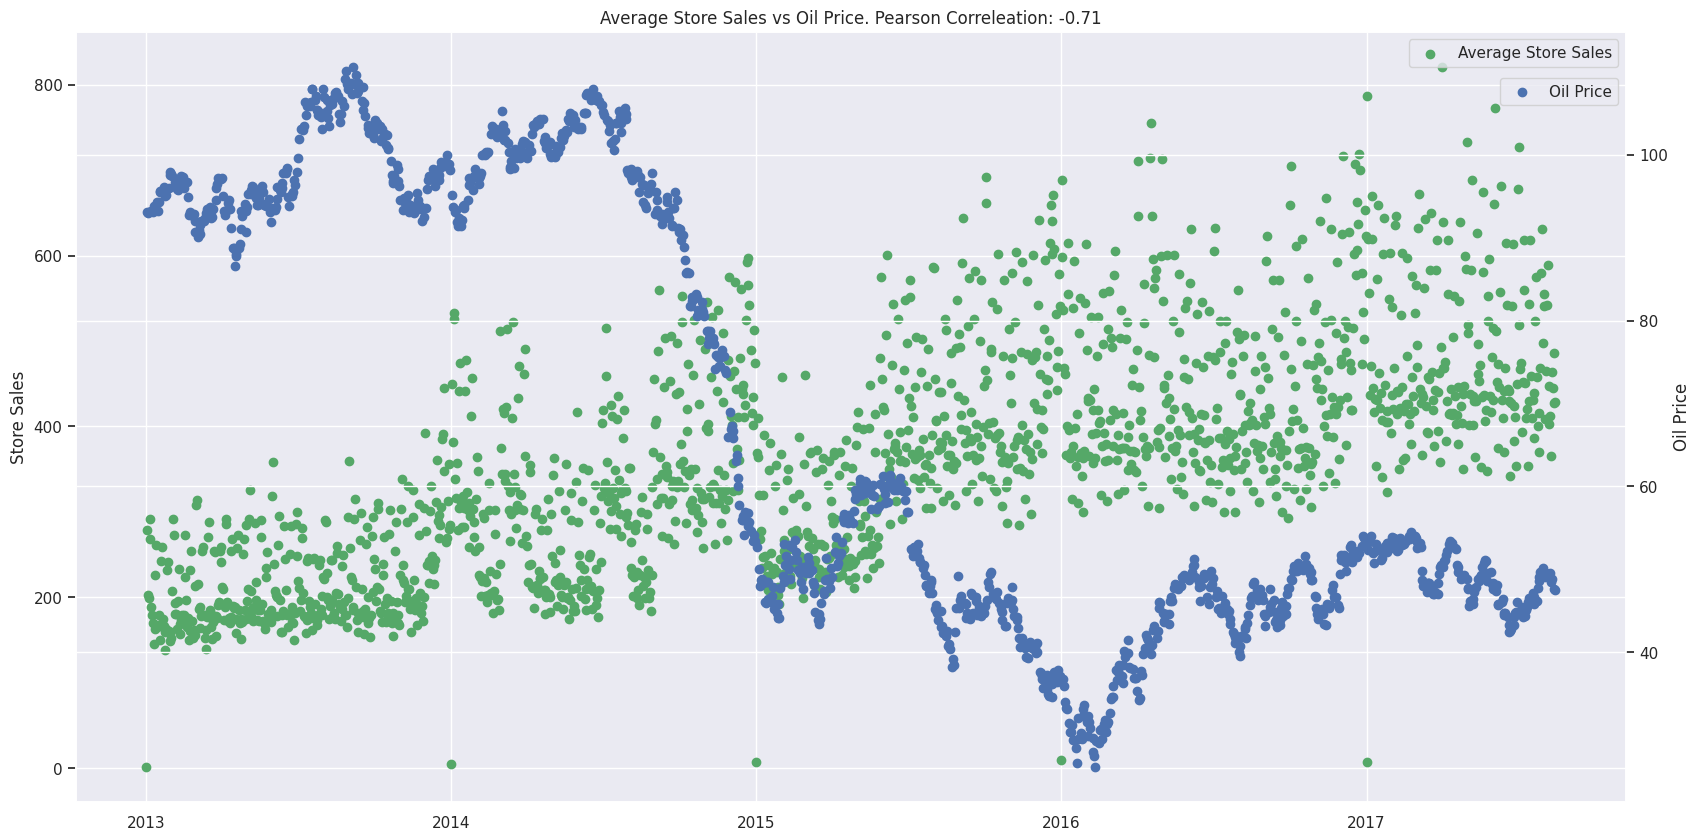

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()

ax1.scatter(sales_oil['date'], sales_oil['sales'], color="g", label='Average Store Sales')
ax1.set_ylabel('Store Sales')

ax2.scatter(sales_oil['date'], sales_oil['dcoilwtico'], color="b", label='Oil Price')
ax2.set_ylabel('Oil Price')

ax1.legend(bbox_to_anchor=(1,1))
ax2.legend(bbox_to_anchor=(1,0.95))

plt.title(f'Average Store Sales vs Oil Price. Pearson Correleation: {pearson_correlation:.2f}')
plt.show()

In [ ]:
print(oil['date'].min())
print(oil['date'].max())

2013-01-01 00:00:00
2017-08-31 00:00:00


## Oil - Insight
* We have 73 Null values to deal with, we may be able to take a moving average to fill these
* We have a fairly strong negative correlelation between store sales and oil price so this will make a useful feature


# Feature Engineering

## Train/Test
* Generate date-related features such as year, month, and weekday.
* Instead of setting a specific payday flag, leverage the day of the month, as this inherently captures trends related to increased sales post-payday.
* Develop lag sales features to track past sales patterns.

In [ ]:
# add dummy sales column to test so we can concat
test['sales'] = 0
train_test = pd.concat([train,test])

In [ ]:
train_test['date'] = train_test['date'].astype('datetime64[ns]')
train_test['year'] = train_test['date'].dt.year
train_test['dayofyear'] = train_test['date'].dt.dayofyear
train_test['quarter'] = train_test['date'].dt.quarter
train_test['weekofyear'] = train_test['date'].dt.weekofyear
train_test['weekday'] = train_test['date'].dt.dayofweek
train_test['month'] = train_test['date'].dt.month
train_test['day'] = train_test['date'].dt.day

<ipython-input-17-9764c49baa54>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_test['weekofyear'] = train_test['date'].dt.weekofyear


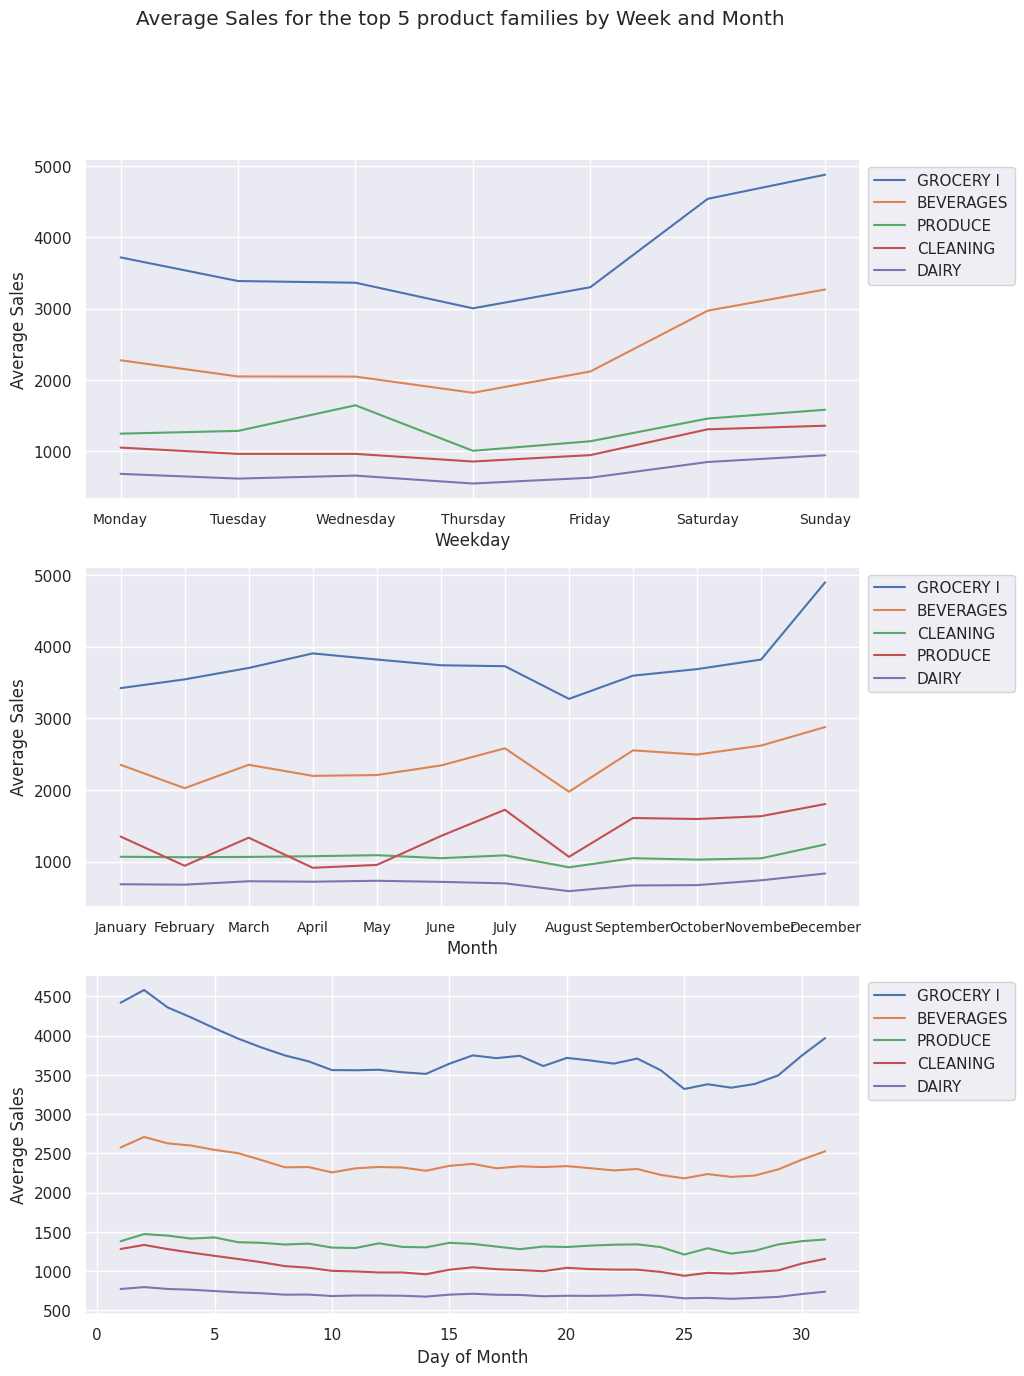

In [ ]:
# Plot Average Sales for top 5 product families by day of week and month to show how they are affected
weekday_sales_by_family = pd.crosstab(index = train_test['family'], columns=train_test['weekday'], values=train_test['sales'], aggfunc='mean').sort_values(by=[0], ascending=False).iloc[0:5,:]
month_sales_by_family = pd.crosstab(index = train_test['family'], columns=train_test['month']-1, values=train_test['sales'], aggfunc='mean').sort_values(by=[1], ascending=False).iloc[0:5,:]
day_of_month_sales_by_family = pd.crosstab(index = train_test['family'], columns=train_test['day'], values=train_test['sales'], aggfunc='mean').sort_values(by=[1], ascending=False).iloc[0:5,:]

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10,15))


# plot weeks
plt.subplot(3,1,1)
for w_f in weekday_sales_by_family.iterrows():

    plt.plot(w_f[1], label=w_f[0])

plt.xticks(range(len(weekdays)), weekdays, size='small')
plt.ylabel('Average Sales')
plt.xlabel('Weekday')
plt.legend(bbox_to_anchor=(1,1))

# plot months
plt.subplot(3,1,2)
for m_f in month_sales_by_family.iloc[0:5,:].iterrows():

    plt.plot(m_f[1], label=m_f[0])

plt.xticks(range(len(months)), months, size='small')
plt.ylabel('Average Sales')
plt.xlabel('Month')
plt.legend(bbox_to_anchor=(1,1))

# plot day of month
plt.subplot(3,1,3)
for m_f in day_of_month_sales_by_family.iterrows():

    plt.plot(m_f[1], label=m_f[0])

plt.ylabel('Average Sales')
plt.xlabel('Day of Month')
plt.legend(bbox_to_anchor=(1,1))

plt.suptitle('Average Sales for the top 5 product families by Week and Month')

plt.show()


In [ ]:
# look at autocorrelation
train_mean = train[['date','sales']].groupby(['date']).mean()

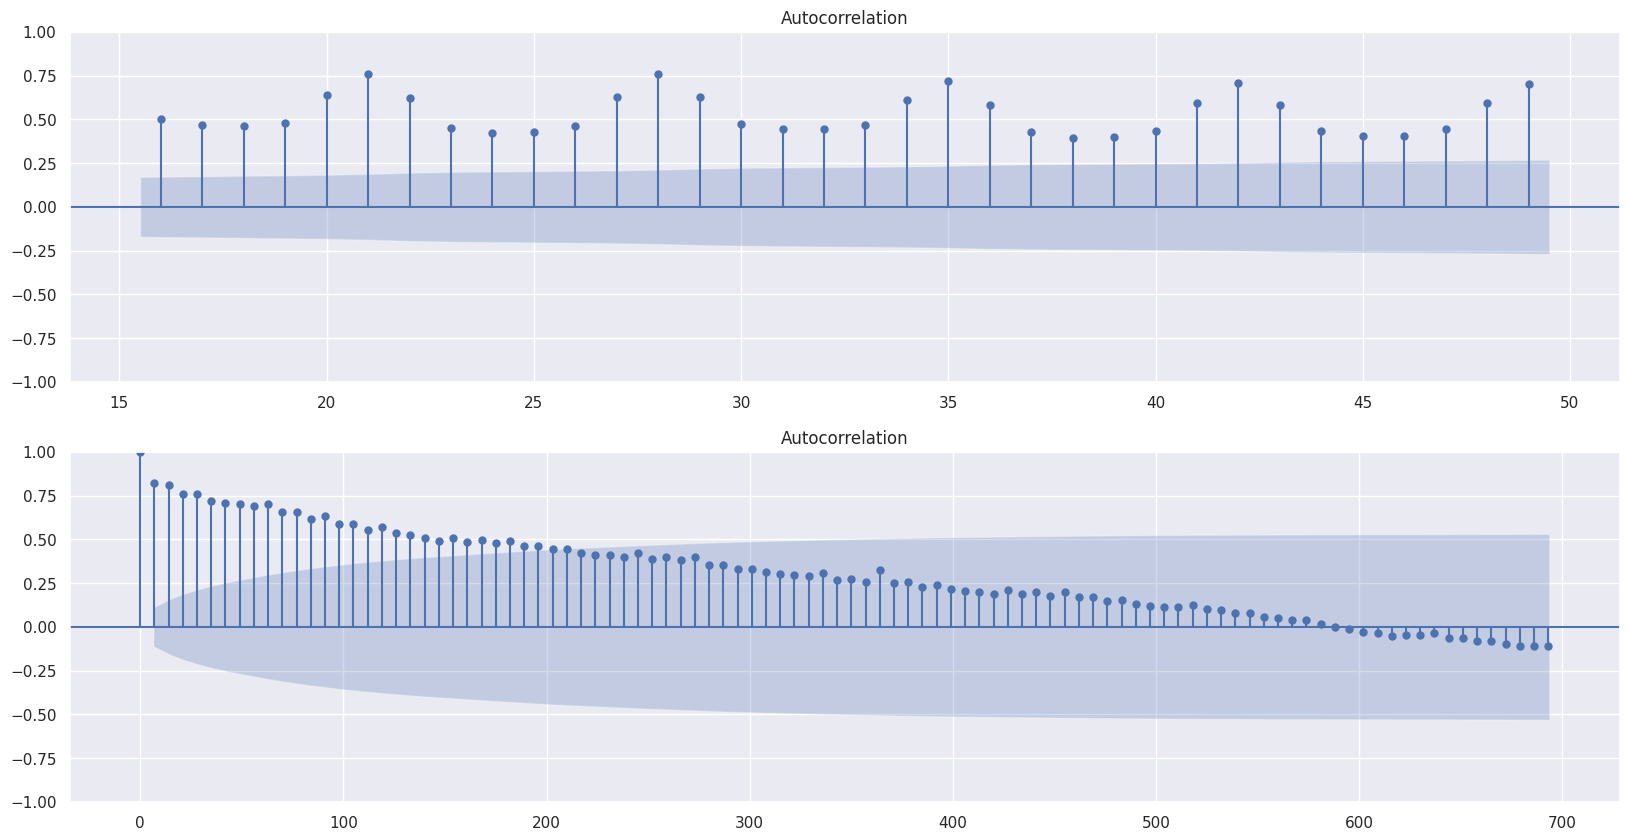

In [ ]:
fig, ax = plt.subplots(2, figsize=(20, 10))

plot_acf(train_mean, lags=np.arange(16,50,1), alpha=0.05, ax=ax[0]);

plot_acf(train_mean, lags=np.arange(0,700,7), alpha=0.05, ax=ax[1]);
plt.show()

In [ ]:
# use the below lags
train_lags = [16,17,18,21,28,35,42]

In [ ]:
store_nbrs = train['store_nbr'].unique()
families = train['family'].unique()

In [ ]:
# create lag features
for store in store_nbrs:

    for family in families:

        store_family_index = (train_test['store_nbr'] == store) & (train_test['family'] == family)


        for lag in train_lags:

            train_test.loc[store_family_index,f'transactions-{lag}'] = train_test.loc[store_family_index,'sales'].shift(lag)

## Transactions
* Add lag features

In [ ]:
date_dummy = pd.DataFrame(pd.date_range(start=train['date'].min(), end=test['date'].max()), columns=['date'])
store_nbr_dummy = pd.DataFrame(store_nbrs, columns=['store_nbr'])

transactions_dummy = date_dummy.merge(store_nbr_dummy, how='cross')

transactions = transactions_dummy.merge(transactions, how='left', left_on=['date','store_nbr'], right_on=['date','store_nbr']).fillna(0)

In [ ]:
# Look at autocorrelation
transactions_mean = transactions[['date','transactions']].groupby(['date']).mean()

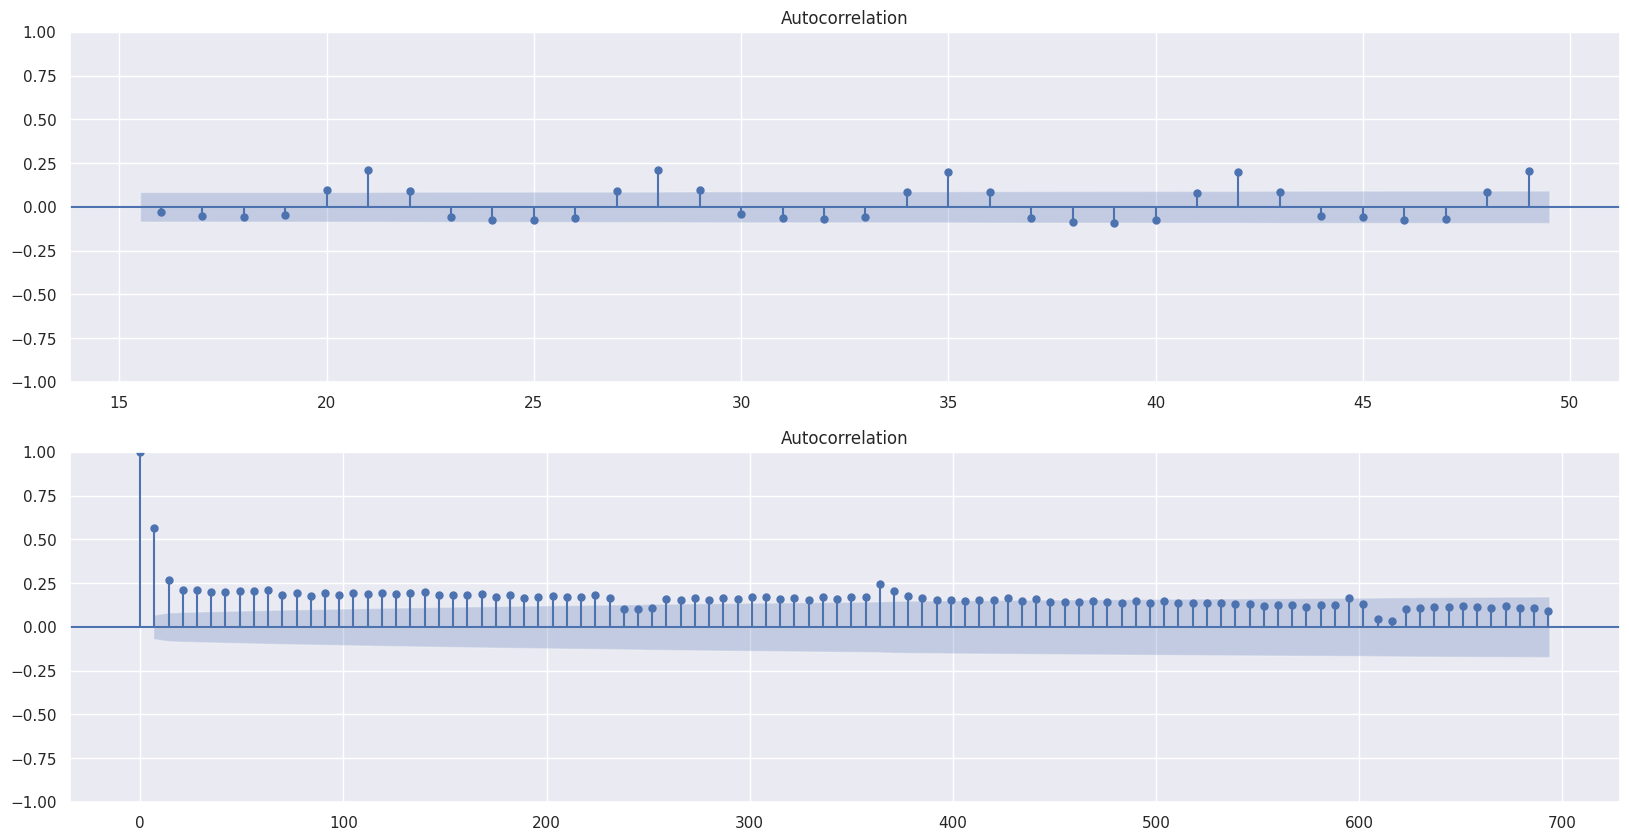

In [ ]:
fig, ax = plt.subplots(2, figsize=(20, 10))

plot_acf(transactions_mean, lags=np.arange(16,50,1), alpha=0.05, ax=ax[0]);


plot_acf(transactions_mean, lags=np.arange(0,700,7), alpha=0.05, ax=ax[1]);
plt.show()

In [ ]:
transaction_lags = [18,20,21,22,24,25,26,28,70,140,210,365]

In [ ]:
for store in store_nbrs:

    store_family_index = transactions['store_nbr'] == store

    for lag in transaction_lags:

        transactions.loc[store_family_index,f'transactions-{lag}'] = transactions.loc[store_family_index,'transactions'].shift(lag)

In [ ]:
transactions = transactions.drop(['transactions'], axis=1)
transactions = transactions.dropna()

## Stores
* We will one-hot-encode the catagorical variables, but leaving the orignal columns for merging the data (will be dropped later on)

In [ ]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
store_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

stores_encoded_array = store_encoder.fit_transform(stores[['city','state','type','cluster']])

stores = pd.concat([stores,stores_encoded_array], axis=1)

stores = stores.drop(['type'], axis=1)

In [ ]:
stores.head()

,store_nbr,city,state,cluster,city_Ambato,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,1,Quito,Pichincha,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,Quito,Pichincha,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Quito,Pichincha,8,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Quito,Pichincha,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Santo Domingo,Santo Domingo de los Tsachilas,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Holidays Events
* Focusing on national Holidays for now
* We need to deal with the transferred column. Currently the type for all of these is Tranfer, but we should set to the original holiday type for decisioning and just use the transferred flag as an indicator
* Create holiday_type from first word of description (need to strip off before '-' in some cases)
* We also have duplicate days with 2 different holidays so need to account for that
* We will one-hot-encode the catagorical variables, but leaving the orignal columns for merging the data (will be dropped later on)

In [ ]:
# remove non-national holidays
holidays_events = holidays_events[holidays_events['locale'] == 'National']

In [ ]:
## we've just got 8 transferred holidays to deal with
holidays_events[holidays_events['type'] == 'Transfer'].head(10)

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [ ]:
# join original holiday onto transferred holiday by details
original_dates = holidays_events[holidays_events['transferred'] == True]
trasnferred_dates = holidays_events[holidays_events['type'] == 'Transfer']

original_dates['index'] = original_dates.index
trasnferred_dates['index'] = trasnferred_dates.index


full_merge = pd.merge(original_dates
                      ,trasnferred_dates
                      ,how='inner'
                      ,on=['locale','locale_name','description']
                      ,suffixes=('_original', '_transferred')
                     ).sort_values(by='date_original')

# calculate date diff to use in filter
full_merge['date_diff'] = (full_merge['date_transferred'] - full_merge['date_original']).dt.days

<ipython-input-32-40edd3a290b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_dates['index'] = original_dates.index
<ipython-input-32-40edd3a290b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trasnferred_dates['index'] = trasnferred_dates.index


In [ ]:
# filter merge where transferred date is within a week of original date
transferred_merge = full_merge[(full_merge['date_diff'] <= 7) & (full_merge['date_diff'] > 0)]
transferred_merge.head(10)

,date_original,type_original,locale,locale_name,description,transferred_original,index_original,date_transferred,type_transferred,transferred_transferred,index_transferred,date_diff


In [ ]:
# update Type of transferred date to the origial Type (in this case Holiday for all), and set transferred to True to indicate a moved date. Delete all of the origianl dates as they are more like normal days
holidays_events.loc[transferred_merge['index_transferred'], 'type'] = 'Holiday'
holidays_events.loc[transferred_merge['index_transferred'], 'transferred'] = 'True'

holidays_events = holidays_events.drop(transferred_merge['index_original'], axis=0)

In [ ]:
# Take first word from description and use as a new feature - override original column since the rest isn't useful (just references locale_name)
holidays_events['description'] = holidays_events['description'].str.split(' ').str[0].str.split('-').str[0].str.split('+').str[0]

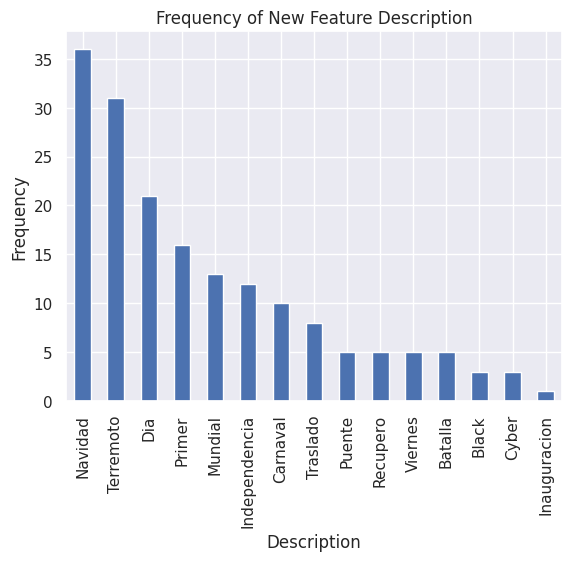

In [ ]:
holidays_events['description'].value_counts().plot(kind='bar')

plt.title('Frequency of New Feature ''Description''')
plt.xlabel('Description')

plt.ylabel('Frequency')
plt.show()

### Dedupe National Holiday data
* some days have multiple rows for national holidays so encode all and then capture the duplicate rows data in one set of encoded columns

In [ ]:
# We also have some dates that have multiple natinal holidays entries which could duplicate rows when concatenated
# Solution is to one hot encode rows and take max of encoded columns so we can account for having multiple holiday data in the same row
holidays_dupe_flag = (holidays_events.groupby('date')['type'].count() > 1)
holidays_events = holidays_events.merge(holidays_dupe_flag, how='left', on='date').sort_values(by=['date','type_x'])

holidays_events = holidays_events.rename(columns={'type_x':'type'
                                          ,'type_y':'dupe_flag'})

In [ ]:
holidays_events

,date,type,locale,locale_name,description,transferred,dupe_flag
0,2012-08-10,Holiday,National,Ecuador,Primer,False,False
1,2012-10-09,Holiday,National,Ecuador,Independencia,True,False
2,2012-10-12,Transfer,National,Ecuador,Traslado,False,False
3,2012-11-02,Holiday,National,Ecuador,Dia,False,False
4,2012-11-03,Holiday,National,Ecuador,Independencia,False,False
...,...,...,...,...,...,...,...
169,2017-12-22,Additional,National,Ecuador,Navidad,False,False
170,2017-12-23,Additional,National,Ecuador,Navidad,False,False
171,2017-12-24,Additional,National,Ecuador,Navidad,False,False
172,2017-12-25,Holiday,National,Ecuador,Navidad,False,False


In [ ]:
# view duped national holidays
holidays_events[holidays_events['dupe_flag'] == True]

,date,type,locale,locale_name,description,transferred,dupe_flag
9,2012-12-24,Additional,National,Ecuador,Navidad,False,True
8,2012-12-24,Bridge,National,Ecuador,Puente,False,True
13,2012-12-31,Additional,National,Ecuador,Primer,False,True
12,2012-12-31,Bridge,National,Ecuador,Puente,False,True
72,2014-12-26,Additional,National,Ecuador,Navidad,False,True
71,2014-12-26,Bridge,National,Ecuador,Puente,False,True
117,2016-05-01,Event,National,Ecuador,Terremoto,False,True
116,2016-05-01,Holiday,National,Ecuador,Dia,False,True
123,2016-05-07,Additional,National,Ecuador,Dia,False,True
124,2016-05-07,Event,National,Ecuador,Terremoto,False,True


In [ ]:
holiday_encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

holiday_encoded = holiday_encoder.fit_transform(holidays_events[['type','locale','locale_name','description']])

holidays_events = pd.concat([holidays_events,holiday_encoded], axis=1)

holidays_events = holidays_events.drop(['type','locale','description'], axis=1)

In [ ]:
## remove dupe rows, tranform and then re-insert
holidays_events_dupes = holidays_events[holidays_events['dupe_flag'] == 1]

holidays_events = holidays_events.drop(holidays_events_dupes.index, axis=0)

holidays_events.shape

(162, 27)

In [ ]:
holiday_dupes_deduped = holidays_events_dupes.groupby(['date']).max().reset_index()

In [ ]:
holidays_events = pd.concat([holidays_events,holiday_dupes_deduped], axis=0)
holidays_events = holidays_events.drop(['dupe_flag'], axis=1)

<ipython-input-42-b106367df6f6>:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  holidays_events = pd.concat([holidays_events,holiday_dupes_deduped], axis=0)


## Oil
* Need to fill na columns
* we're missing some dates from the dataset (e.g. 5th Jan 2013) so we need to create the correct data range and work from that to fill na values
* use a 5 day moving average to impute null values


In [ ]:
train_start = train['date'].min()
train_end = train['date'].max()
test_start = test['date'].min()
test_end = test['date'].max()

date_range = pd.DataFrame(pd.date_range(start=train_start, end=test_end), columns=['date'])

In [ ]:
oil = date_range.merge(oil, how='left', left_on=['date'], right_on=['date'])

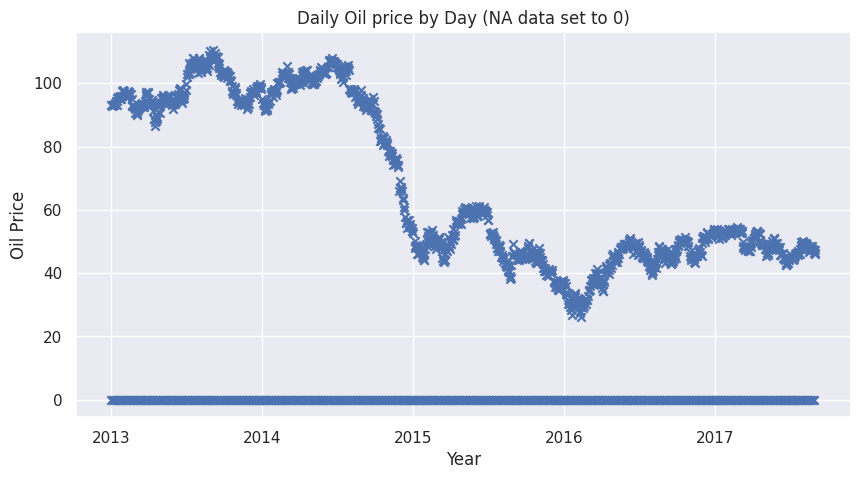

In [ ]:
oil['date'] = oil['date'].astype('datetime64[ns]')
plt.figure(figsize=(10,5))
plt.scatter(oil['date'], oil['dcoilwtico'].fillna(0), marker='x')

plt.xlabel('Year')
plt.ylabel('Oil Price')
plt.title('Daily Oil price by Day (NA data set to 0)')
plt.show()

In [ ]:
# fill na columns with 5 day rolling average centred on the point
oil_na_mask = oil['dcoilwtico'].isna()

oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].rolling(5, center=True, min_periods=1).mean())

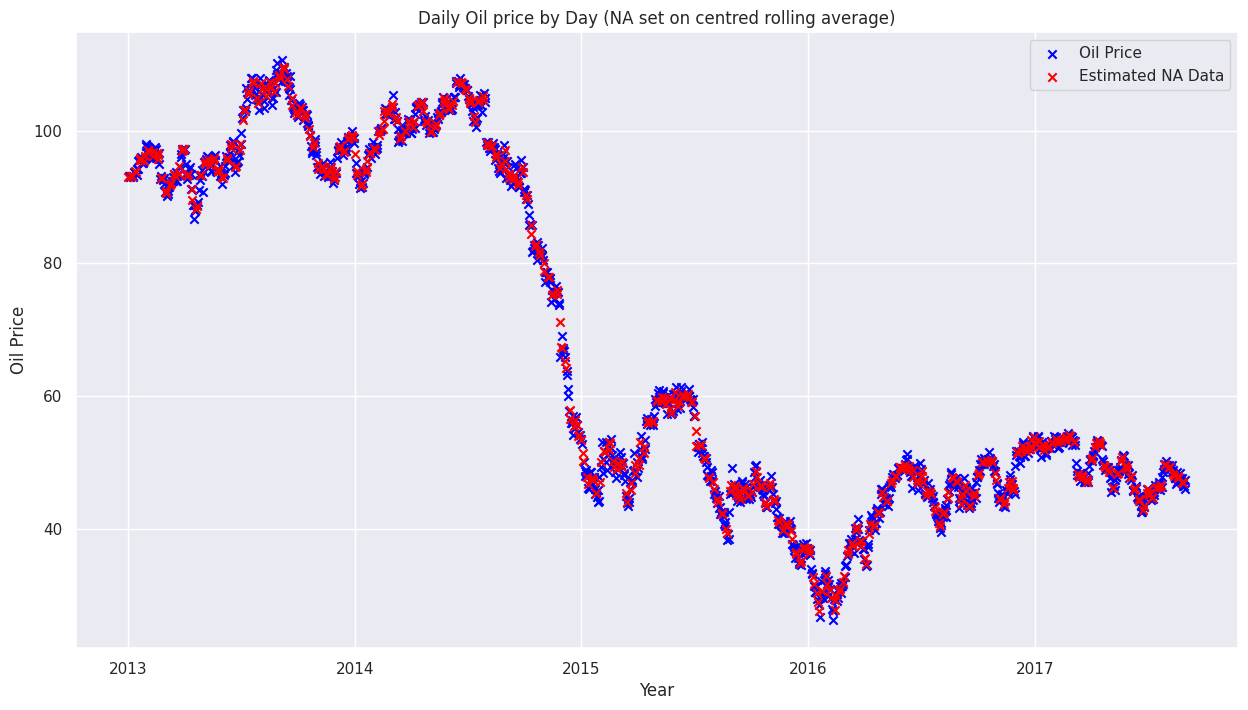

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(oil[~oil_na_mask]['date'], oil[~oil_na_mask]['dcoilwtico'], color='blue', marker='x', label='Oil Price')
plt.scatter(oil[oil_na_mask]['date'], oil[oil_na_mask]['dcoilwtico'], color='red', marker='x', label='Estimated NA Data')

plt.xlabel('Year')
plt.ylabel('Oil Price')
plt.title('Daily Oil price by Day (NA set on centred rolling average)')
plt.legend()
plt.show()
